# **IN SEARCH FOR FAIRNESS IN MACHINE LEARNING MODEL : COMPAS DATASET**

Authors


*   Manuel **SULMONT**
*   Nairit **BANDYOPADHYAY**
*   Archit **YADAV**


In this project, we aim to work on given dataset of COMPAS dataset, published by ProPublica. This dataset contains information on criminal defendants with their COMPAS score and if they did actually recidivate two years after. We aim to do the following:


1.   To clean the dataset and perform some basic data exploration.
2.   To use some general classifier on the dataset.
3.   To create a fair classifier (which is supposed to classify more fairly  compared to the general classifiers).



### STEP 1 : DOWNLOADING THE DATA

In [1]:
import urllib
import urllib.request
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle
from __future__ import division
from collections import defaultdict
from sklearn import metrics
import matplotlib.pyplot as plt
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file {} in the current directory...".format(fname))

    if fname not in files:
        print("{} not found! Downloading from GitHub...".format(fname))
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("{} download and saved locally..".format(fname))
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file compas-scores-two-years.csv in the current directory...
File found in current directory..


### STEP 3: CLEAN THE DATA SET

The ProPublica article : https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm does not clearly define any methodology on how to clean the data.However their analysis notebook (https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) provided some guidelines on how to clean the data:

1. If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
2. We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
3. In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
4. We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [2]:
#read file using panda and drop out the missing val

df = pd.read_csv(COMPAS_INPUT_FILE)
print("Original Entries in dataset")
print(df.shape)
print("-------------------------------------------------")


df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
print(df.shape)
#print("-------------------------------------------------")


print("On further processing of the data........")
df = df[(df.days_b_screening_arrest <= 30) & (df.days_b_screening_arrest >= -30) & (df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A') ]
df.reset_index(inplace=True, drop=True) 

print("Valid Entries in dataset")
print(df.shape)
print("-------------------------------------------------")


print("Do we still have some empty rows for some features? Let's see")
print(df.isnull().sum())
print("-------------------------------------------------")

Original Entries in dataset
(7214, 53)
-------------------------------------------------
(6907, 53)
On further processing of the data........
Valid Entries in dataset
(6172, 53)
-------------------------------------------------
Do we still have some empty rows for some features? Let's see
id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest       0
c_jail_in                     0
c_jail_out                    0
c_case_number                 0
c_offense_date              784
c_arrest_date              5388
c_days_from_compas            0
c_char

### STEP 4 : BASIC EXPLORATION OF DATA

In [3]:
def printing_groupby_aggregator(datafram,list_of_group_by_attributes,measured_attribute,aggregate_function,title):
  print(title)
  frame = datafram.groupby(list_of_group_by_attributes)[measured_attribute].agg(aggregate_function)
  print(frame,'\n')
  print("-------------------------------------------------\n")
  return 

Here we will see the features of the dataset and will try to see the unique races,charge degree,Gender and ages present in the dataset

In [4]:
print("Features in the dataset")
print(df.columns)
print("-------------------------------------------------\n")
print("First 20 rows in dataset")
print(df.head(20))
print("-------------------------------------------------")
print("Different races in dataset")
print(df.race.unique(),"\n") 
print("-------------------------------------------------")
print("Different charge degrees")
print(df.c_charge_degree.unique(),"\n") 
print("-------------------------------------------------")
print("Different gender in dataset")
print(df.sex.unique(),"\n")
print("-------------------------------------------------")
print("Different ages in dataset")
print(np.sort(df.age.unique()))
print("-------------------------------------------------")





Features in the dataset
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')
-------------------------

We will count the number of people for some of the features

In [5]:

printing_groupby_aggregator(df,['age_cat'],'age','count',"Number of People by Age")
printing_groupby_aggregator(df,['race'],'race','count',"Number of People by Race")
printing_groupby_aggregator(df,['decile_score'],'decile_score','count',"Number of People by Compas Score")
printing_groupby_aggregator(df,['score_text'],'score_text','count',"Number of People by Risk")



Number of People by Age
age_cat
25 - 45            3532
Greater than 45    1293
Less than 25       1347
Name: age, dtype: int64 

-------------------------------------------------

Number of People by Race
race
African-American    3175
Asian                 31
Caucasian           2103
Hispanic             509
Native American       11
Other                343
Name: race, dtype: int64 

-------------------------------------------------

Number of People by Compas Score
decile_score
1     1286
2      822
3      647
4      666
5      582
6      529
7      496
8      420
9      420
10     304
Name: decile_score, dtype: int64 

-------------------------------------------------

Number of People by Risk
score_text
High      1144
Low       3421
Medium    1607
Name: score_text, dtype: int64 

-------------------------------------------------



Sex and Race

sex               Female  Male
race                          
African-American     549  2626
Asian                  2    29
Caucasian            482  1621
Hispanic              82   427
Native American        2     9
Other                 58   285 

-------------------------------------------------
Decile score and Race
decile_score       1    2    3    4    5    6    7    8    9    10
race                                                              
African-American  365  346  298  337  323  318  343  301  317  227
Asian              15    4    5    0    1    2    1    2    0    1
Caucasian         605  321  238  243  200  160  113   96   77   50
Hispanic          159   89   73   47   39   27   28   14   17   16
Native American     0    2    1    0    0    2    2    0    2    2
Other             142   60   32   39   19   20    9    7    7    8 

-------------------------------------------------
Mean of Decile_score based on Race and Sex
race              sex   
African-

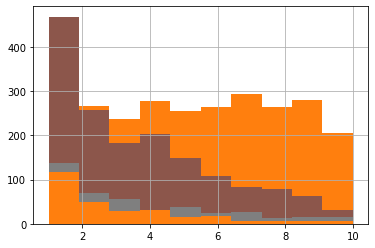

In [6]:
#by sex and race
print("Sex and Race\n")
print(pd.crosstab(df['race'], df['sex']),'\n')
print("-------------------------------------------------")
#by score and race
print("Decile score and Race")
print(pd.crosstab(df['race'], df['decile_score']),'\n')
print("-------------------------------------------------")



printing_groupby_aggregator(df,['race','sex'],'decile_score','mean',"Mean of Decile_score based on Race and Sex")
printing_groupby_aggregator(df,['race','sex'],'decile_score','hist',"Hist of Decile_score based on Race and Sex")

In [7]:
df_caucasian = df[df.race == 'Caucasian']
df_african = df[df.race == 'African-American']
df_caucasian=df_caucasian.groupby(['decile_score'])['decile_score'].count()
df_african=df_african.groupby(['decile_score'])['decile_score'].count()


<AxesSubplot:title={'center':"Black defendant's Decile Scores"}, xlabel='decile_score'>

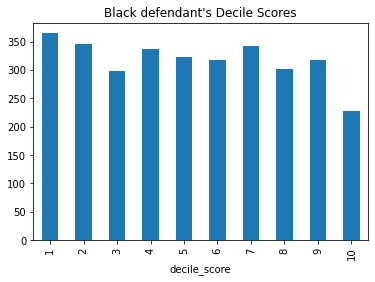

In [8]:
df_african.plot(x='decile_score',kind='bar',title='Black defendant\'s Decile Scores')


<AxesSubplot:title={'center':"White defendant's Decile Scores"}, xlabel='decile_score'>

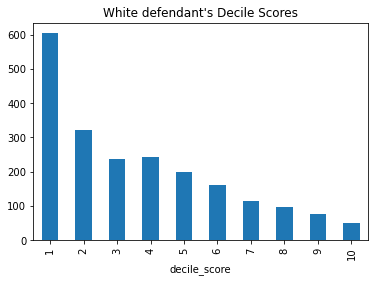

In [9]:
df_caucasian.plot(x='decile_score',kind='bar',title='White defendant\'s Decile Scores')

In [10]:
print("Total People in the dataset")
print(df.shape[0],'\n')

print("People who were re-arrested")
print(df['two_year_recid'].sum(),'\n')


printing_groupby_aggregator(df,['race'],'two_year_recid','sum',"People got re-arrested by race")
printing_groupby_aggregator(df,['score_text','race'],'race','count',"People got different categories of compas scores based on race")

Total People in the dataset
6172 

People who were re-arrested
2809 

People got re-arrested by race
race
African-American    1661
Asian                  8
Caucasian            822
Hispanic             189
Native American        5
Other                124
Name: two_year_recid, dtype: int64 

-------------------------------------------------

People got different categories of compas scores based on race
score_text  race            
High        African-American     845
            Asian                  3
            Caucasian            223
            Hispanic              47
            Native American        4
            Other                 22
Low         African-American    1346
            Asian                 24
            Caucasian           1407
            Hispanic             368
            Native American        3
            Other                273
Medium      African-American     984
            Asian                  4
            Caucasian            473
         

**OBSERVATIONS**
1. The decile scores of white defendants are on the lower side,while that of black defendants are on the higher side.

2. Another striking observation is COMPAS gave high and medium scores to 1829 black defendants but only 1661 were rearrested. Meanwhile 696 white defendants were given high and medium scores but 822 were arrested. It means COMPAS maybe falsely predicting black defendants as more-dangerous compared to white defendants

## FEATURE ENGINEERING

We will be using pandas dummies for one-hot encoding. The idea is to distribute the categorical features into seperate columns. We don't need all the features of the dataset. We will be removing some and create new features from the categorical features also called flattening the dataset.

In [11]:
dummies = pd.get_dummies(df.age_cat)
merged = pd.concat([df,dummies],axis='columns')
final1 = merged.drop(['age_cat','Less than 25'],axis = 'columns')

dummies = pd.get_dummies(final1.race)
merged = pd.concat([final1,dummies],axis='columns')
final2 = merged.drop(['Other','race'],axis = 'columns')

dummies = pd.get_dummies(final2.sex)
merged = pd.concat([final2,dummies],axis='columns')
final3 = merged.drop(['sex','Female'],axis = 'columns')

dummies = pd.get_dummies(final3.c_charge_degree)
merged = pd.concat([final3,dummies],axis='columns')
final4 = merged.drop(['c_charge_degree','F'],axis = 'columns')

final4[["priors_count"]] = preprocessing.scale(df[["priors_count"]])

print ("\nNumber of people recidivating within two years is {}".format(final4.two_year_recid.sum()))


final4.columns
Independent = final4[['25 - 45','Greater than 45','African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American',
       'Male', 'M','priors_count']]

Dependent = final4.two_year_recid

print(Independent.head(20))
print(Dependent.head(20))



Number of people recidivating within two years is 2809
    25 - 45  Greater than 45  African-American  Asian  Caucasian  Hispanic  \
0         0                1                 0      0          0         0   
1         1                0                 1      0          0         0   
2         0                0                 1      0          0         0   
3         1                0                 0      0          0         0   
4         1                0                 0      0          1         0   
5         1                0                 0      0          0         0   
6         1                0                 0      0          1         0   
7         1                0                 0      0          1         0   
8         0                0                 1      0          0         0   
9         1                0                 0      0          1         0   
10        1                0                 1      0          0         0   
11      

The independent dataframe contains the independet features of the dataset and dependent dataframe contains the feature that has to be predicted by the training model.

### TEST TRAIN SPLIT

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Independent,Dependent,test_size=0.2,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4937, 10)
(1235, 10)
(4937,)
(1235,)


### MULTILAYER PERCEPTRON

In [13]:
from sklearn.metrics import plot_confusion_matrix

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(5, 4))
mlp.fit(X_train,y_train)
mlp_y=mlp.predict(X_test)
print("Accuracy :",accuracy_score(y_test, mlp_y))

Accuracy : 0.6890688259109312


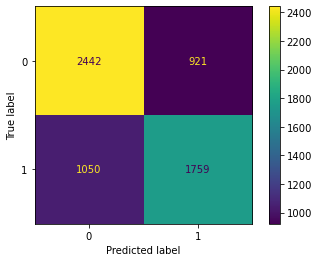

In [15]:
plot_confusion_matrix(mlp, Independent, Dependent)
plt.show()

## Gaussian NB Classification

In [16]:
#GaussianNB 
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train,y_train)
gnb_y=gnb.predict(X_test)
print("Accuracy :",accuracy_score(y_test, gnb_y))

Accuracy : 0.631578947368421


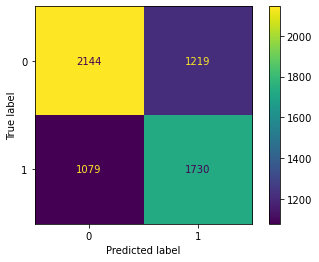

In [17]:
plot_confusion_matrix(gnb, Independent, Dependent)
plt.show()

## SVM Classifier

In [18]:
from sklearn import svm
svm=svm.SVC()
svm.fit(X_train,y_train)
svm_y=svm.predict(X_test)
print("Accuracy :",accuracy_score(y_test,svm_y))

Accuracy : 0.6631578947368421


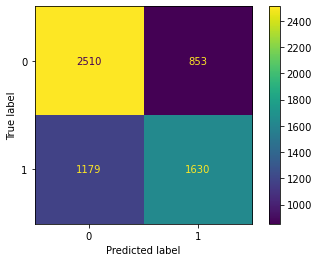

In [19]:
plot_confusion_matrix(svm, Independent, Dependent)
plt.show()

## ROC AUC PLOT

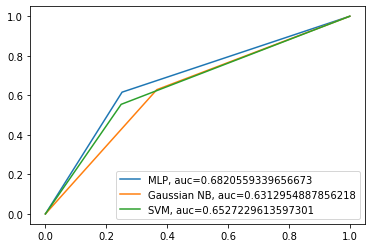

In [20]:
mlp_fpr, mlp_tpr, _ = metrics.roc_curve(y_test,mlp_y)
mlp_auc = metrics.roc_auc_score(y_test,mlp_y)
plt.plot(mlp_fpr,mlp_tpr,label="MLP, auc="+str(mlp_auc))

gnb_fpr, gnb_tpr, _ = metrics.roc_curve(y_test,gnb_y)
gnb_auc = metrics.roc_auc_score(y_test, gnb_y)
plt.plot(gnb_fpr,gnb_tpr,label="Gaussian NB, auc="+str(gnb_auc))

svm_fpr, svm_tpr, _ = metrics.roc_curve(y_test,svm_y)
svm_auc = metrics.roc_auc_score(y_test, svm_y)
plt.plot(svm_fpr,svm_tpr,label="SVM, auc="+str(svm_auc))

plt.legend(loc=4)
plt.show()

# FAIRNESS IN THE CLASSIFIER

We need to verify whether the Compas Algorithm produces significant difference in the scores depending on the race of the offender.

First we will create a Logestic Regression model (https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb). We are selecting the features like charge-degree,Age category,Race,Gender,Number of prior counts and the two year recid for training the model.

We will be predicting the Compas score factor.



In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')

df_crime = pd.get_dummies(df['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(df['age_cat'],prefix='age')
df_race = pd.get_dummies(df['race'],prefix='race')
df_gender = pd.get_dummies(df['sex'],prefix='sex',drop_first=True)
df_score1 = pd.get_dummies(df['score_text']!= 'Low'  ,prefix='score_factor',drop_first=True)


df_independent = pd.concat([df_crime, df_age,df_race,df_gender,df['priors_count'],df['two_year_recid']],axis=1)
df_dependent = df_score1.score_factor_True

The accuracy of the model is around 75%.

In [22]:
clf = lr.fit(df_independent,df_dependent)
score = clf.score(df_independent, df_dependent)
print(score)

0.7508101101749838


In [23]:
predicted = lr.predict(df_independent)
predicted_recid_fair=pd.Series(predicted)==1 
actual_recid_fair=df.two_year_recid==1

Now we will check the intercept and coefficient for all the features.

In [24]:
print( "The intercept is {}".format(clf.intercept_))
print("--------------------------------------------------------------")
for i,j in zip(df_independent.columns, clf.coef_[0]): print('%f' % j, i)

The intercept is [-1.33461667]
--------------------------------------------------------------
-0.309965 crimefactor_M
0.017544 age_25 - 45
-1.328085 age_Greater than 45
1.318982 age_Less than 25
0.490014 race_African-American
-0.200754 race_Asian
0.012625 race_Caucasian
-0.409056 race_Hispanic
0.908992 race_Native American
-0.793380 race_Other
-0.218662 sex_Male
0.268415 priors_count
0.683334 two_year_recid


We will use these coefficients and intercepts to see how likely are the other races compared to the white defendants.
 
 
 Credits : https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb



In [25]:
control = np.exp(-1.33461667) / (1 + np.exp(-1.33461667))
black = np.exp(clf.coef_[0][4]) / (1 - control + (control * np.exp(clf.coef_[0][4])))
asian = np.exp(clf.coef_[0][5]) / (1 - control + (control * np.exp(clf.coef_[0][5])))
White = np.exp(clf.coef_[0][6]) / (1 - control + (control * np.exp(clf.coef_[0][6])))
Native = np.exp(clf.coef_[0][7]) / (1 - control + (control * np.exp(clf.coef_[0][7])))
Other = np.exp(clf.coef_[0][8]) / (1 - control + (control * np.exp(clf.coef_[0][8])))
print('Black defendants: %f' % black)
print('Asian defendents: %f' % asian)
print('White defendents: %f' % White)
print('Native defendents: %f' % Native)
print('Other defendents: %4f' % Other)

Black defendants: 1.442279
Asian defendents: 0.850345
White defendents: 1.010030
Native defendents: 0.714249
Other defendents: 1.896247


Black defendants are 44% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.Similarly Other defendents are 89% more likely to receive a higher score.

g_recid  False  True 
a_recid              
False     2345   1018
True      1076   1733


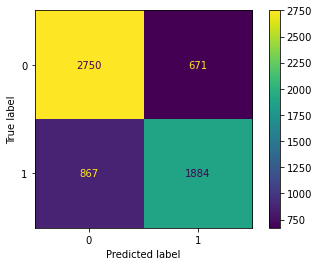

In [26]:
df['g_recid'] = df['score_text'] != 'Low'             #The new column guessed_recid will contain boolean values depending on the values in score_text column
df['a_recid'] = df.two_year_recid == 1                # The score_text contains text data and the two_year_recid contains integer.So we are converting both to boolean
                                                      # So that we can represent the values of TN,TP,FN,FP properly in the confusion matrix
cm = pd.crosstab(df.a_recid, df.g_recid)
print(cm) # for "confusion matrix"

plot_confusion_matrix(clf, df_independent, df_dependent)
plt.show()


If we compare it with the general classifiers described above we will see that logistic regression has less FP and FN and more TN and TP compared to the general classifiers.

In [27]:
print('STATISTICS FOR WHITE CRIMINALS')
print("-------------------------------------------------------------------------------")

subset = df.race == 'Caucasian'
cm1 = pd.crosstab(actual_recid_fair[subset], predicted_recid_fair[subset],rownames=['actual'], colnames=['guessed'])
print(cm1)
print("The False Positive Rate {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))
#print("The Accuracy of the model {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))
print("The Accuracy is {}".format((cm1[True][True]+cm1[False][False])/(cm1[True][False]+cm1[False][False]+cm1[True][True]+cm1[False][True])))

print('STATISTICS FOR BLACK CRIMINALS')
print("-------------------------------------------------------------------------------")
subset1 = df.race == 'African-American'
cm2 = pd.crosstab(actual_recid_fair[subset1], predicted_recid_fair[subset1],rownames=['actual'], colnames=['guessed'])
print(cm2)
print("The False Positive Rate {}".format(cm2[True][False]/(cm2[True][False]+cm2[False][False])))
#print("The Accuracy of the model {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))
print("The Accuracy is {}".format((cm2[True][True]+cm2[False][False])/(cm2[True][False]+cm2[False][False]+cm2[True][True]+cm2[False][True])))

STATISTICS FOR WHITE CRIMINALS
-------------------------------------------------------------------------------
guessed  False  True 
actual               
False     1165    116
True       441    381
The False Positive Rate 0.09055425448868072
The Accuracy is 0.7351402757964812
STATISTICS FOR BLACK CRIMINALS
-------------------------------------------------------------------------------
guessed  False  True 
actual               
False      959    555
True       288   1373
The False Positive Rate 0.3665785997357992
The Accuracy is 0.7344881889763779


In [28]:

TN = cm[False][False]
TP = cm[True][True]
FN = cm[False][True]
FP = cm[True][False]
print(TN,TP,FN,FP)

2345 1733 1076 1018


### FALSE POSITIVE RATE : COMPAS CLASSIFIES A BLACK DEFENDANT AS HIGH RISK BUT THE DEFENDENT IS NOT REARRESTED IN TWO YEARS


Now we will see that the False Positive rate for a black defendant is almost 90% higher than a white defendant. It means a black defendent is 90% more likely to be falsely classified as high-risk criminal even though has not been rearrested in 2 years.

In [29]:
print('STATISTICS FOR WHITE CRIMINALS')
print("-------------------------------------------------------------------------------")
subset_white = df[df.race == 'Caucasian']
cm1 = pd.crosstab(subset_white.a_recid, subset_white.g_recid)
print(cm1)
#print(FP / (FP + TN))
print("The False Positive Rate {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))

STATISTICS FOR WHITE CRIMINALS
-------------------------------------------------------------------------------
g_recid  False  True 
a_recid              
False      999    282
True       408    414
The False Positive Rate 0.22014051522248243


In [30]:
print('STATISTICS FOR BLACK CRIMINALS')
print("-------------------------------------------------------------------------------")
subset_black = df[df.race == 'African-American']
cm2 = pd.crosstab(subset_black.a_recid, subset_black.g_recid)
print(cm2)
print("The False Positive Rate {}".format(cm2[True][False]/(cm2[True][False]+cm2[False][False])))

STATISTICS FOR BLACK CRIMINALS
-------------------------------------------------------------------------------
g_recid  False  True 
a_recid              
False      873    641
True       473   1188
The False Positive Rate 0.4233817701453104


In [31]:
((0.42-0.22)/0.22)*100


90.9090909090909

In [32]:
print('STATISTICS FOR OTHER CRIMINALS')
print("-------------------------------------------------------------------------------")
subset_other = df[df.race == 'Other']
cm3 = pd.crosstab(subset_other.a_recid, subset_other.g_recid)
print(cm3)
print(cm3[True][False]/(cm3[True][False]+cm3[False][False]))

STATISTICS FOR OTHER CRIMINALS
-------------------------------------------------------------------------------
g_recid  False  True 
a_recid              
False      191     28
True        82     42
0.1278538812785388


All these observations clearly suggests that there is some problem with COMPAS algorithm when it comes to predicting scores for defendants of various races. The predictions are skewed on race and makes it unfair.

### OUR ATTEMPT ON BUILDING A FAIR CLASSIFIER

We decided to remove the features like Age category,Race and Sex from the features.Instead we will use only charge-degree and priors-count.Obviously the accuracy of the model will be low because we are using less parameters but what is important to observe is whether still there remains any bias or not.

In [33]:
Independent_fair = pd.concat([pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True),df.priors_count],axis = 'columns')
Dependent_fair = df.two_year_recid


Our accuracy has fallen by 10% on using the same logistic regression.This is because we are using a lower number of parameters.

In [34]:
lr = LogisticRegression()
clf = lr.fit(Independent_fair,Dependent_fair)
score = clf.score(Independent_fair, Dependent_fair)
print(score)

0.6422553467271549


In [35]:
print( "The intercept is {}".format(clf.intercept_))
print("--------------------------------------------------------------")
for i,j in zip(Independent_fair.columns, clf.coef_[0]): print('%f' % j, i)

The intercept is [-0.50875275]
--------------------------------------------------------------
-0.345934 degree_M
0.147285 priors_count


We will use the model to predict the two_year_recid. We will compare this with the actual two_year_recid of the dataset


In [36]:
predicted = lr.predict(Independent_fair)
predicted_recid_fair=pd.Series(predicted)==1 
actual_recid_fair=df.two_year_recid==1
cm3 = pd.crosstab(actual_recid_fair,predicted_recid_fair,rownames=['actual'], colnames=['guessed'])
cm3

guessed,False,True
actual,,
False,2845,518
True,1690,1119


The False positives rate has decreased for both the blacks and whites but still a black defendant is two times likely than white defendant to be misclassified as High risk.Thus our classifier has :


*   Low accuracy
*   Less number of False positives
*   FPR of Black = 2 * FPR of White




In [37]:
print('STATISTICS FOR WHITE CRIMINALS')
print("-------------------------------------------------------------------------------")

subset = df.race == 'Caucasian'
cm1 = pd.crosstab(actual_recid_fair[subset], predicted_recid_fair[subset],rownames=['actual'], colnames=['guessed'])
print(cm1)
print("The False Positive Rate {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))
#print("The Accuracy of the model {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))
print("The Accuracy is {}".format((cm1[True][True]+cm1[False][False])/(cm1[True][False]+cm1[False][False]+cm1[True][True]+cm1[False][True])))

print('STATISTICS FOR BLACK CRIMINALS')
print("-------------------------------------------------------------------------------")
subset1 = df.race == 'African-American'
cm2 = pd.crosstab(actual_recid_fair[subset1], predicted_recid_fair[subset1],rownames=['actual'], colnames=['guessed'])
print(cm2)
print("The False Positive Rate {}".format(cm2[True][False]/(cm2[True][False]+cm2[False][False])))
#print("The Accuracy of the model {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))
print("The Accuracy is {}".format((cm2[True][True]+cm2[False][False])/(cm2[True][False]+cm2[False][False]+cm2[True][True]+cm2[False][True])))


STATISTICS FOR WHITE CRIMINALS
-------------------------------------------------------------------------------
guessed  False  True 
actual               
False     1143    138
True       583    239
The False Positive Rate 0.10772833723653395
The Accuracy is 0.6571564431764146
STATISTICS FOR BLACK CRIMINALS
-------------------------------------------------------------------------------
guessed  False  True 
actual               
False     1182    332
True       871    790
The False Positive Rate 0.2192866578599736
The Accuracy is 0.6211023622047244


Clearly our classifier is not working as expected.Let us dig deeper.

On facing this challenge we tried consulting with several online articles and journals to get some idea on how to proceed.We found one article named : https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb

Here we found that one way of creating Fair algorithms is "Optimization at Training Time". So we looked into this reference article : https://people.mpi-sws.org/~mzafar/papers/disparate_mistreatment.pdf [Zafar et.al.(2016)] The Compas algorithm has disparate mistreatment on FPR. So we will try to optimize the FPR. In particular we will try to implement something similar to **Covariance vs FPR** where decreasing the covariance threshold converges the FPR of both the groups **[Fairness Beyond Disparate Treatment & Disparate Impact:
Learning Classification without Disparate Mistreatment,Zafar et.al.(2016), page 6].** Here instead of Covariance we will use a normal threshold that will be used in the classifiction function.

We define a list known as **probability of recidivism** which contains the probability of prediction for the two_year_recid to fall in class 1.We define two variables known as **others_threshold** and **black_threshold** such that **others_threshold + black_threshold = 1**. We will decrease the value of others_threshold (the black_threshold will automatically increase) and then we replace the predicted values for those black defendents whose probability of recidivism is greater than the black_threshold.


In short: we are forcing our classifier to mark high-risk to those black candidates only if the predicted probability of obtaining high-risk (calculated using predict_proba of sklearn) is greater that a certain threshold.And this certain threshold is known as black threshold which is higher. This means less number of black defendents will be classified as high-risk.Subsequently if black_threshold is high then others_threshold will be lower because black+other = 1. This means that non black people will be marked as high-risk by our classifier for small values of predicted probability.This will certainly bring a balance in the FPR or both black and white but as expected it will increase FN for black defendants as high threshold removes some true "high-risk" black defendants.

In [38]:
    def FairnessEnforcer(others_threshold,black_threshold,regression_model):
      probability_of_recidivism = regression_model.predict_proba(Independent_fair)[:,1]
      prediction_for_all = pd.Series(probability_of_recidivism > others_threshold)
      prediction_for_all.loc[df.race=='African-American'] = pd.Series(probability_of_recidivism > black_threshold)
      print('STATISTICS FOR WHITE CRIMINALS')
      print("-------------------------------------------------------------------------------")
      subset = df.race == 'Caucasian'
      cm1 = pd.crosstab(actual_recid_fair[subset], prediction_for_all[subset],rownames=['actual'], colnames=['guessed'])
      print(cm1)
      print("The False Positive Rate {}".format(cm1[True][False]/(cm1[True][False]+cm1[False][False])))
      print("The Accuracy is {}".format((cm1[True][True]+cm1[False][False])/(cm1[True][False]+cm1[False][False]+cm1[True][True]+cm1[False][True])))
      print('STATISTICS FOR BLACK CRIMINALS')
      print("-------------------------------------------------------------------------------")
      subset1 = df.race == 'African-American'
      cm2 = pd.crosstab(actual_recid_fair[subset1], prediction_for_all[subset1],rownames=['actual'], colnames=['guessed'])
      print(cm2)
      print("The False Positive Rate {}".format(cm2[True][False]/(cm2[True][False]+cm2[False][False])))
      print("The Accuracy is {}".format((cm2[True][True]+cm2[False][False])/(cm2[True][False]+cm2[False][False]+cm2[True][True]+cm2[False][True])))
      return

At tuning parameter 0.45 (we started with 0.5), we found that the FPR of both black and white is the closest to each other. Needless to say that if we decrease the tuning parameter,then the FPR of white defandants will increase by large amount.

In [39]:
Tuning_parameter = 0.45
FairnessEnforcer(Tuning_parameter,1-Tuning_parameter,lr)

STATISTICS FOR WHITE CRIMINALS
-------------------------------------------------------------------------------
guessed  False  True 
actual               
False     1078    203
True       516    306
The False Positive Rate 0.15846994535519127
The Accuracy is 0.6581074655254399
STATISTICS FOR BLACK CRIMINALS
-------------------------------------------------------------------------------
guessed  False  True 
actual               
False     1255    259
True       986    675
The False Positive Rate 0.17107001321003962
The Accuracy is 0.6078740157480315


So now our classifier has :

*   Low accuracy for black criminals
*   Low number of False positives for black criminals
*   FPR of Black = 1.08 * FPR of White





### CONCLUSION

The accuracy of our classifier has decreased by 2% for the black defendants but the FPR of Black now almost similar to the FPR of White. So we are satisfied with our results. What we have understood is it is difficult to create a fairness classifier because for achieving fainess we have to optimize simultaneously various parameters. This is a difficult problem for optimisation and often it is seen that balancing one parameter can lead to imbalance in other parameters ("Trade-off"). In our model we see that FPR decreases but FN increases and overall accuracy decreases a bit. So a trade-off between FPR and Accuracy is being displayed by our model.
And removing features like Race or Age category does not essentially remove the biasness.
